In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tokenizer/keras/default/1/tokenizer.pkl
/kaggle/input/lstmmodel/keras/default/1/LSTMmodel.h5


# 1. Loading the dataset (from hugging face)
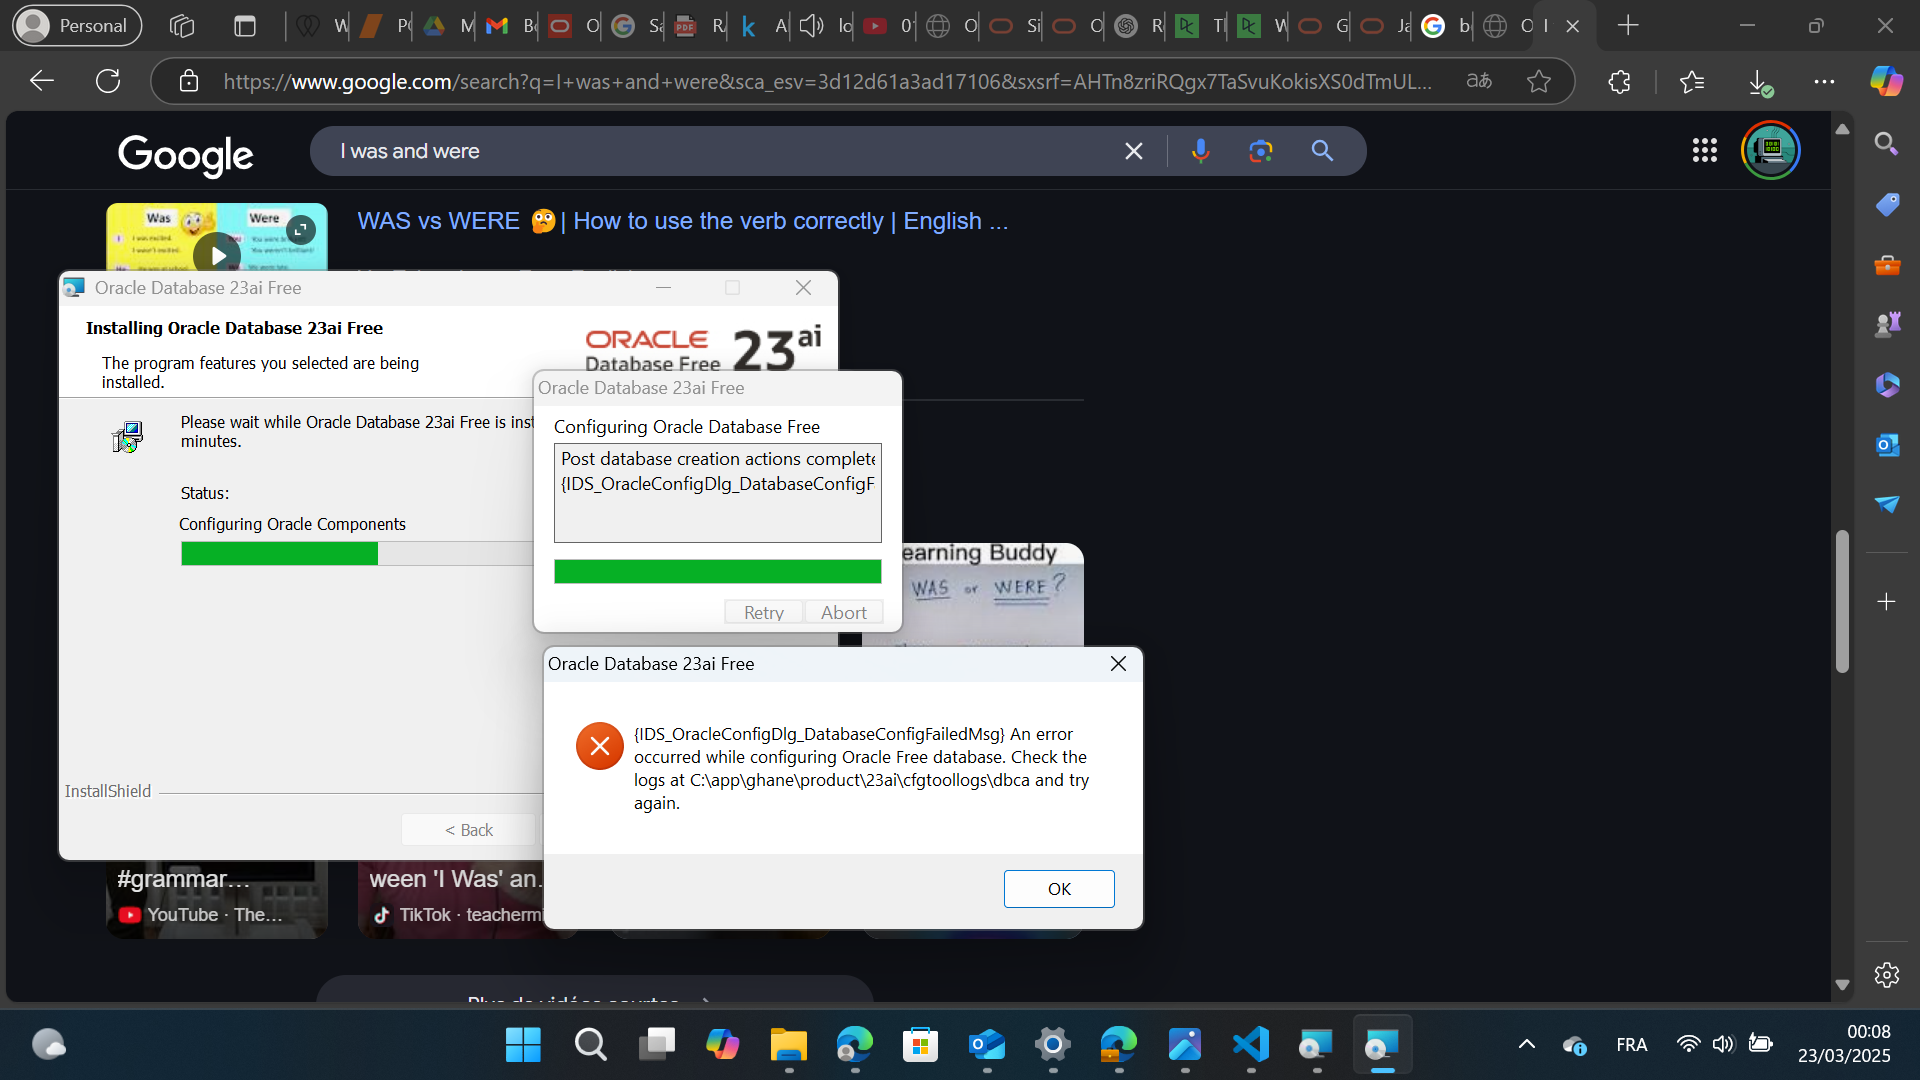

In [35]:
!pip install datasets --quiet
from datasets import load_dataset

# Load the dataset
ds = load_dataset("shahxeebhassan/human_vs_ai_sentences")


# 2. Importing the required python libraries and Packages 

In [36]:
from datasets import load_dataset
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import tensorflow as tf


# 3. EDA: Display informations and samples from the dataset (DatasetDict)

In [37]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 105000
    })
})


In [38]:
# Display an example
print(ds["train"][0])

{'text': 'Another reason why all students should have to participate in at least one extracurricular activity is because it develops stronger social skills.', 'label': 0}


# 4. EDA: Check label distribution and missing values 

In [39]:
from collections import Counter

# Check label distribution before splitting
label_counts = Counter(ds['train']['label'])
print(label_counts)


Counter({0: 52500, 1: 52500})


In [40]:
# Check for missing values in your dataset using the correct columns
missing_values = sum(1 for example in ds['train'] if example['label'] is None or example['text'] is None)
print(f"Missing values in the dataset: {missing_values}")



Missing values in the dataset: 0


# 5. Splitting the Dataset into train and val sets 

In [41]:
# Split the dataset into train and validation sets (80-20 split)
train_val_split = ds["train"].train_test_split(test_size=0.2)
train_dataset = train_val_split["train"]
val_dataset = train_val_split["test"]

In [42]:
print("Training Set:")
print(train_dataset[:5])  # Print the first 5 records from the training set

print("\nValidation Set:")
print(val_dataset[:5])  # Print the first 5 records from the validation set


Training Set:
{'text': ['One of the best ways to travel is in a group led by a tour guide.', 'Another important aspect of failure is that it can help us develop empathy and compassion for others.', "Cell phone use can also impair a driver's judgment and decision making.", 'As a result, setting curfews can be an effective tool in helping teenagers to stay safe, secure, and academically successful.', 'Lastly, homework helps students develop responsibility and discipline.'], 'label': [1, 1, 1, 1, 1]}

Validation Set:
{'text': ['The face was "formed by shadows giving illusion of eyes, nose, and mouth".', 'Cars produce greenhouse gases that contribute to climate change, and they also pollute the air with exhaust fumes.', 'Students, on the other hand, should focus on studying what is presented to them to acquire the knowledge and skills necessary for success.', "In exploring the concept of failure and its role in achieving success, it is important to consider Winston Churchill's words about 

# 6. Plotting the text length distribution in training set

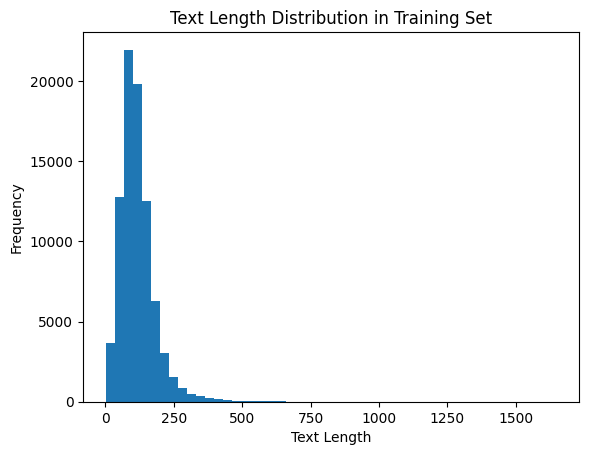

In [43]:
import matplotlib.pyplot as plt 
text_lengths = [len(example['text']) for example in train_dataset]
plt.hist(text_lengths, bins=50)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Text Length Distribution in Training Set')
plt.show()


# 7. Tokenization and padding the text data 

In [44]:
# Initialize the tokenizer
vocab_size = 20000  #  vocabulary size
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_dataset["text"])

# Function to tokenize and pad sequences
max_length = 128

def tokenize_and_pad(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=max_length, padding="post", truncating="post")

# Tokenize and pad the text data
X_train = tokenize_and_pad(train_dataset["text"])
X_val = tokenize_and_pad(val_dataset["text"])

In [45]:
# Convert labels to NumPy arrays
y_train = np.array(train_dataset["label"])
y_val = np.array(val_dataset["label"])
print( type (y_train) )
print(type (y_val)) 

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


# 8. Saving the Tokenizer 

In [46]:
import pickle

# Save tokenizer to a file
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


# 9. Building a bidirectional LSTM model for our Binary Classification

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
import tensorflow as tf

# Define model parameters
embedding_dim = 128

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(64, return_sequences=False),  # LSTM layer with 64 units
    Dropout(0.5),  # Dropout for regularization
    Dense(1, activation="sigmoid")  # Sigmoid activation for binary classification
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Display model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# 10. Training the model along with applying the Early stopping

In [ ]:
# Early stopping to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
batch_size = 32  # You can adjust this value
num_epochs = 20
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=num_epochs,
    callbacks=[early_stopping],
    verbose=1
)

# 11. Evaluating the model 

In [ ]:
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# 12. Predictions 

In [ ]:
predictions = model.predict(X_val)

print(predictions)

# 13. Plotting the loss & accuracy curves

In [ ]:
# Plot loss & accuracy curves
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss Over Epochs")

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy Over Epochs")

plt.show()


# 14. Saving the model

In [ ]:
# Save the model to a file (e.g., 'model.h5')
model.save('LSTMmodel.h5')

# 15. Deploying the saved model using Streamlit

In [52]:
!pip install streamlit pyngrok --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 63.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 82.1 MB/s eta 0:00:00:00:0100:01


In [53]:
%%writefile app.py

import streamlit as st
import tensorflow as tf
import numpy as np
import pickle
import re
import string
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the trained model
model = tf.keras.models.load_model("/kaggle/input/lstmmodel/keras/default/1/LSTMmodel.h5")  # Change path if needed

# Load the saved tokenizer
with open("/kaggle/input/tokenizer/keras/default/1/tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# Define preprocessing function
max_length = 128  # Ensure this matches the training value

def preprocess_text(text):
    text = text.lower().strip()
    text = re.sub(f"[{string.punctuation}]", "", text)
    seq = tokenizer.texts_to_sequences([text])
    padded_seq = pad_sequences(seq, maxlen=max_length, padding="post")
    return padded_seq

# --- CUSTOM CSS FOR A PREMIUM LOOK WITH ANIMATIONS ---
st.markdown(
    """
    <style>
        /* Background */
        .main { background: #1E1E1E; color: white; padding: 20px; border-radius: 12px; }

        /* Move Title Up */
        h1 { margin-top: -40px; text-align: center; font-weight: bold; color: #00C896; }

        /* Text Input */
        .stTextArea textarea { 
            font-size: 18px; 
            border-radius: 12px; 
            border: none;  /* Removed red border */
            background: #2C2C2C; 
            color: white;
            padding: 12px;
            width: 100%;  /* Ensures the text area spans the width */
        }

        /* Check Button - With Animation */
        .stButton>button { 
            background: linear-gradient(135deg, #00C896, #008080); 
            color: white; font-size: 18px; font-weight: bold; 
            border-radius: 10px; padding: 12px; 
            transition: all 0.3s ease-in-out; border: none;
            box-shadow: 0px 4px 10px rgba(0, 200, 150, 0.3);
            width: 100%; /* Make the button take up the full width of the container */
        }
        .stButton>button:hover { 
            background: linear-gradient(135deg, #008080, #005F5F); 
            transform: scale(1.05);
            box-shadow: 0px 6px 15px rgba(0, 200, 150, 0.5);
        }

        /* Result Box */
        .result-box { 
            font-size: 20px; font-weight: bold; padding: 12px; 
            border-radius: 12px; text-align: center; margin-top: 15px; 
        }
        .ai { background-color: rgba(255, 0, 0, 0.2); color: red; border-left: 5px solid red; }
        .human { background-color: rgba(0, 255, 0, 0.2); color: #00C896; border-left: 5px solid #00C896; }

        /* Styled Prediction Text */
        .ai-text { color: red; font-weight: bold; }
        .human-text { color: #00C896; font-weight: bold; }

        /* Footer */
        .footer { 
            position: fixed; bottom: 10px; left: 0; width: 100%; text-align: center; 
            font-size: 14px; color: white; font-family: 'Courier New', monospace; 
        }

        /* GitHub Icon */
        .github {
            display: flex;
            justify-content: center;
            align-items: center;
            margin-top: 15px;
        }
        .github a {
            text-decoration: none; 
            color: white;
            font-size: 16px;
            font-weight: bold;
            display: flex;
            align-items: center;
            gap: 8px;
        }
        .github img {
            width: 20px;
            height: 20px;
        }
    </style>
    """,
    unsafe_allow_html=True,
)

# --- APP TITLE ---
st.title("Human vs. AI Text Detector")

# --- USER INPUT ---
with st.container():
    user_input = st.text_area(
        "Type or paste text below:", 
        placeholder="Please enter more than 40 words for better accuracy...",
        height=150
    )

    # --- CHECK BUTTON ---
    if st.button("Check"):
        if user_input:
            processed_text = preprocess_text(user_input)
            prediction = model.predict(processed_text)[0][0]
            is_ai = prediction > 0.5
            label = '<span class="ai-text">AI-generated</span>' if is_ai else '<span class="human-text">Human-written</span>'
            confidence = prediction if is_ai else 1 - prediction

            # Show Results
            st.markdown("### Prediction: " + label, unsafe_allow_html=True)
            st.progress(float(confidence))  # Shows confidence level

            st.markdown(
                f'<div class="result-box {"ai" if is_ai else "human"}"> '
                f"Confidence: {confidence:.2%} </div>",
                unsafe_allow_html=True,
            )
        else:
            st.warning("Please enter some text before clicking 'Check'!")

# --- FOOTER WITH GITHUB LINK ---
st.markdown(
    """
    <div class="github">
        <a href="https://github.com/YourGitHubUsername" target="_blank">
            <img src="https://cdn-icons-png.flaticon.com/512/25/25231.png" alt="GitHub"> 
            Follow me on GitHub
        </a>
    </div>
    """,
    unsafe_allow_html=True,
)



Overwriting app.py


In [54]:
!ngrok authtoken 2uAow1q0FZhHYoG2CKVocQImM0v_37MHhReq4zXJEhmzgSZ5F

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml                                


In [55]:
import subprocess
from pyngrok import ngrok

# Kill existing ngrok processes (avoid conflicts)
!pkill -f streamlit

# Start Streamlit
process = subprocess.Popen(["streamlit", "run", "app.py"])

# Start ngrok tunnel
url = ngrok.connect(8501)
print(f"🌍 Streamlit is running! Open it here: {url}")

🌍 Streamlit is running! Open it here: NgrokTunnel: "https://fc33-34-141-157-189.ngrok-free.app" -> "http://localhost:8501"


In [9]:
!pkill -f ngrok